In [1]:
import cv2
import numpy as np
import os
import random
from scipy.signal import wiener
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
train_folder = '/kaggle/input/fruits36081class/fruits-360/Training'
total_classes = 0
total_images = 0  # Initialize a variable to store total images

for class_folder in os.listdir(train_folder):
  class_folder_path = os.path.join(train_folder, class_folder)
  if os.path.isdir(class_folder_path):
    total_classes += 1
    images = os.listdir(class_folder_path)
    num_images = len(images)
    print(f"Class: {class_folder}, Number of Images: {num_images}")
    total_images += num_images  # Add current class image count to total

print(f"Total number of classes: {total_classes}")
print(f"Total number of images: {total_images}")

Class: Quince, Number of Images: 490
Class: Grapefruit White, Number of Images: 492
Class: Granadilla, Number of Images: 490
Class: Orange, Number of Images: 479
Class: Apple Red 3, Number of Images: 429
Class: Grape White 2, Number of Images: 490
Class: Tamarillo, Number of Images: 490
Class: Banana Red, Number of Images: 490
Class: Pear Monster, Number of Images: 490
Class: Lemon Meyer, Number of Images: 490
Class: Passion Fruit, Number of Images: 490
Class: Cactus fruit, Number of Images: 490
Class: Pomegranate, Number of Images: 492
Class: Plum, Number of Images: 447
Class: Pineapple, Number of Images: 490
Class: Tomato 1, Number of Images: 738
Class: Cherry 2, Number of Images: 738
Class: Apple Red 2, Number of Images: 492
Class: Avocado ripe, Number of Images: 491
Class: Dates, Number of Images: 490
Class: Maracuja, Number of Images: 490
Class: Papaya, Number of Images: 492
Class: Cherry Wax Yellow, Number of Images: 492
Class: Apple Golden 2, Number of Images: 492
Class: Guava, 

In [3]:
test_folder = '/kaggle/input/fruits36081class/fruits-360/Test'
total_classes = 0
total_images = 0  # Initialize a variable to store total images

for class_folder in os.listdir(test_folder):
  class_folder_path = os.path.join(test_folder, class_folder)
  if os.path.isdir(class_folder_path):
    total_classes += 1
    images = os.listdir(class_folder_path)
    num_images = len(images)
    print(f"Class: {class_folder}, Number of Images: {num_images}")
    total_images += num_images  # Add current class image count to total

print(f"Total number of classes: {total_classes}")
print(f"Total number of images: {total_images}")

Class: Quince, Number of Images: 166
Class: Grapefruit White, Number of Images: 164
Class: Granadilla, Number of Images: 166
Class: Orange, Number of Images: 160
Class: Apple Red 3, Number of Images: 144
Class: Grape White 2, Number of Images: 166
Class: Tamarillo, Number of Images: 166
Class: Banana Red, Number of Images: 166
Class: Pear Monster, Number of Images: 166
Class: Lemon Meyer, Number of Images: 166
Class: Passion Fruit, Number of Images: 166
Class: Cactus fruit, Number of Images: 166
Class: Pomegranate, Number of Images: 164
Class: Plum, Number of Images: 151
Class: Pineapple, Number of Images: 166
Class: Tomato 1, Number of Images: 246
Class: Cherry 2, Number of Images: 246
Class: Apple Red 2, Number of Images: 164
Class: Avocado ripe, Number of Images: 166
Class: Dates, Number of Images: 166
Class: Maracuja, Number of Images: 166
Class: Papaya, Number of Images: 164
Class: Cherry Wax Yellow, Number of Images: 164
Class: Apple Golden 2, Number of Images: 164
Class: Guava, 

# **Importing Libraries** 

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import AutoTokenizer , SwinForImageClassification,ViTForImageClassification
from torchvision import models,transforms, datasets
import torch.optim as optim
import cv2
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torch.optim import lr_scheduler
from torch.optim import AdamW


In [5]:
train_dir = train_folder
test_dir = test_folder
num_classes = total_classes
image_shape = (100, 100)
batch_size = 32

# **Making Dataset**

In [6]:
from torch.utils.data import Dataset
from PIL import Image
import os

class MakeDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.classes = sorted(os.listdir(root_folder), key=self.natural_key)
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self.make_dataset()

    def natural_key(self, string_):
        try:
            return int(string_)
        except ValueError:
            return string_

    def make_dataset(self):
        images = []
        for label in self.classes:
            label_folder = os.path.join(self.root_folder, label)
            for image_name in os.listdir(label_folder):
                image_path = os.path.join(label_folder, image_name)
                item = (image_path, self.class_to_idx[label])
                images.append(item)
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path, label = self.images[index]
        try:
            image = Image.open(image_path).convert("RGB")
        except (OSError, IOError) as e:
            print(f"Skipping corrupted image: {image_path}, Error: {e}")
            # Return a zero tensor and a dummy label in case of error
            image = Image.new('RGB', (100, 100))  # Assuming the image size to be 224x224
            label = -1  # You might want to handle this label properly later

        if self.transform:
            image = self.transform(image)

        return image, label


# **Transformation on the Data**

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the required input size
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=20),   # Rotate the image by up to 20 degrees
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Apply small translations
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])


In [8]:
train_dataset = MakeDataset(train_dir, transform=transform)
test_dataset=MakeDataset(test_dir, transform=transform)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **Data Samples**

Training Samples:


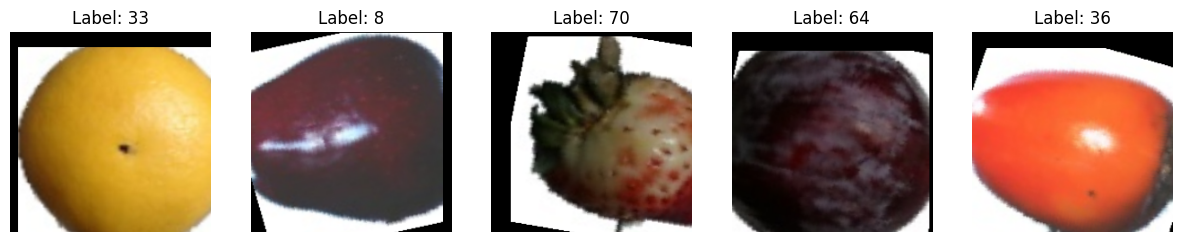

Testing Samples:


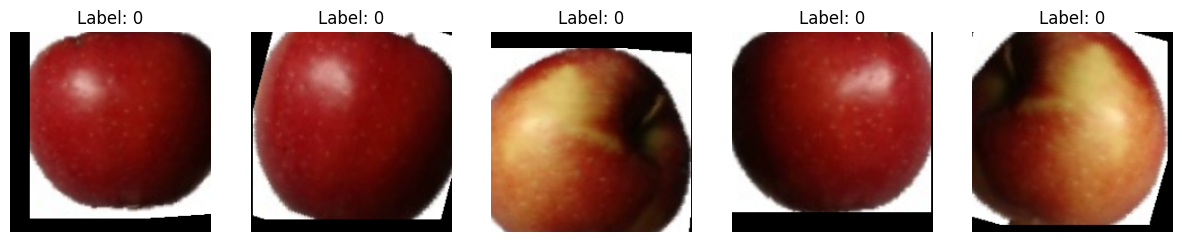

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to visualize images from a DataLoader
def visualize(loader, num_samples=5):
    # Iterate through the DataLoader to get a batch of data
    for batch_idx, (images, labels) in enumerate(loader):
        # Plot the images
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        for i in range(num_samples):
            ax = axes[i]
            ax.imshow(np.transpose(images[i], (1, 2, 0)))
            ax.set_title(f"Label: {labels[i]}")
            ax.axis('off')
        plt.show()
        break  # Stop after displaying the first batch

# Visualize samples from the training loader
print("Training Samples:")
visualize(train_loader)


print("Testing Samples:")
visualize(test_loader)

# **MobileNetV3_Large**

In [11]:
model = models.mobilenet_v3_large(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 121MB/s] 


In [12]:
in_features = model.classifier[0].in_features

# Modify the classifier layer to match the number of output classes
model.classifier = nn.Sequential(
    nn.Linear(in_features, num_classes),
    nn.Softmax(dim=1)
)

In [13]:
best_model_weights = torch.load('/kaggle/input/mobilenetv3/pytorch/default/1/MobileNetV3_Large_best_model_fold_5.pth')

# Apply the weights to the model
model.load_state_dict(best_model_weights)

/tmp/ipykernel_23/952454847.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_weights = torch.load('/kaggle/input/mobilenetv3/pytorch/default/1/MobileNetV3_Larg

<All keys matched successfully>

In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
model = model.to(device)

# **Optimizer & LR**

In [16]:
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

In [17]:
num_epochs = 5
desired_training_accuracy = 99.999
early_stopping_threshold = 3
early_stopping_counter = 0
best_val_loss = float('inf')

In [18]:
from sklearn.model_selection import StratifiedKFold

# Assume `dataset` is your PyTorch dataset
num_folds = 5
# Assuming train_dataset is your dataset
X = np.arange(len(train_dataset))  # Placeholder, you will index the dataset with this
y = np.array([label for _, label in train_dataset])  # Extract labels from the dataset

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold Cross-Validation


In [19]:
import time

start_time = time.time()

# **Training Loop**

In [20]:
# Lists to store the losses and accuracies for each fold
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f'Fold {fold + 1}/{skf.n_splits}')
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

    best_acc = 0  # Reset the best accuracy for each fold
    
    fold_train_losses = []
    fold_train_accuracies = []
    fold_val_losses = []
    fold_val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            if -1 in labels:
                continue  # Skip the batch if it contains dummy labels

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            if i % 100 == 99:
                print(f'Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(train_loader)}, '
                      f'Training Loss: {running_loss / 100}, Training Accuracy: {100 * correct_train / total_train}%')

        training_accuracy = correct_train / total_train
        fold_train_losses.append(running_loss / len(train_loader))
        fold_train_accuracies.append(training_accuracy)

        # Validation
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_running_loss += loss.item()
                _, predicted_val = torch.max(val_outputs.data, 1)
                total_val += val_labels.size(0)
                correct_val += (predicted_val == val_labels).sum().item()

        validation_accuracy = correct_val / total_val
        validation_loss = val_running_loss / len(val_loader)
        fold_val_losses.append(validation_loss)
        fold_val_accuracies.append(validation_accuracy)

        print(f'Validation Accuracy after epoch {epoch + 1}/{num_epochs}: {100 * validation_accuracy}%')

        if validation_accuracy > best_acc:
            best_acc = validation_accuracy
            torch.save(model.state_dict(), f'best_model_fold_{fold + 1}.pth')

        scheduler.step(validation_loss)

    # Store metrics for the entire fold
    train_losses.extend(fold_train_losses)
    train_accuracies.extend(fold_train_accuracies)
    val_losses.extend(fold_val_losses)
    val_accuracies.extend(fold_val_accuracies)



Fold 1/5
Epoch 1/5, Batch 100/1034, Training Loss: 3.4243316578865053, Training Accuracy: 99.09375%
Epoch 1/5, Batch 200/1034, Training Loss: 6.856790459156036, Training Accuracy: 98.75%
Epoch 1/5, Batch 300/1034, Training Loss: 10.287666325569154, Training Accuracy: 98.69791666666667%
Epoch 1/5, Batch 400/1034, Training Loss: 13.717521448135376, Training Accuracy: 98.6875%
Epoch 1/5, Batch 500/1034, Training Loss: 17.148545920848846, Training Accuracy: 98.675%
Epoch 1/5, Batch 600/1034, Training Loss: 20.57860044002533, Training Accuracy: 98.66666666666667%
Epoch 1/5, Batch 700/1034, Training Loss: 24.006219735145567, Training Accuracy: 98.69196428571429%
Epoch 1/5, Batch 800/1034, Training Loss: 27.435759830474854, Training Accuracy: 98.69140625%
Epoch 1/5, Batch 900/1034, Training Loss: 30.88857469558716, Training Accuracy: 98.42361111111111%
Epoch 1/5, Batch 1000/1034, Training Loss: 34.32194409847259, Training Accuracy: 98.403125%
Validation Accuracy after epoch 1/5: 97.7737447065

# **Training Time**

In [21]:
end_time = time.time()

duration_seconds = end_time - start_time
duration_minutes = duration_seconds / 60

print("Training duration: {:.2f} minutes".format(duration_minutes))

Training duration: 112.97 minutes


# **Plotting Training&Validation**

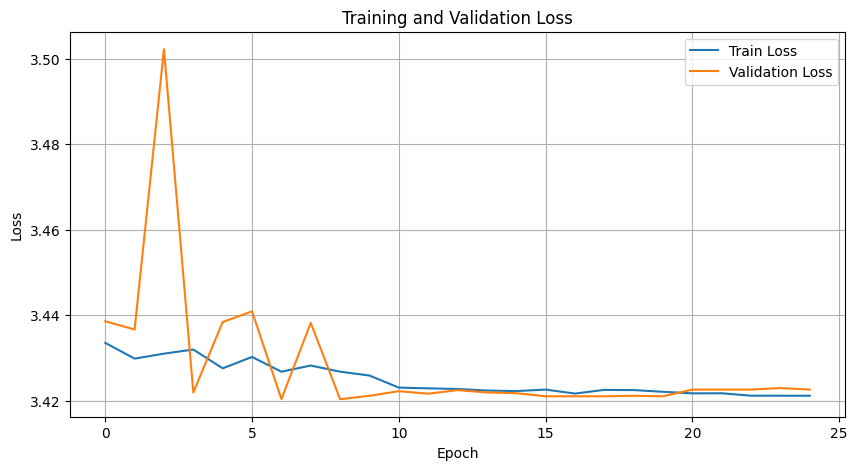

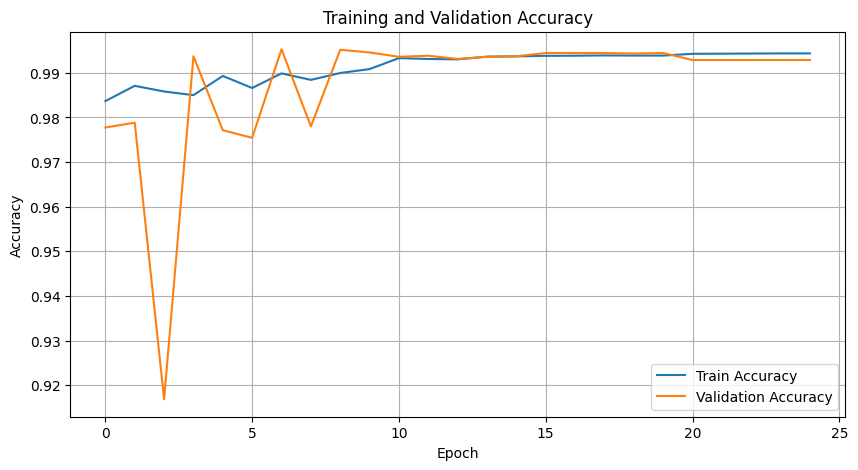

In [22]:
# Plotting Training and Validation Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# **Picking best model**

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [24]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the paths for each fold
model_paths = [
    '/kaggle/working/best_model_fold_1.pth',
    '/kaggle/working/best_model_fold_2.pth',
    '/kaggle/working/best_model_fold_3.pth',
    '/kaggle/working/best_model_fold_4.pth',
    '/kaggle/working/best_model_fold_5.pth'
]

# Placeholder for the best model and best performance
best_model = None
best_f1_score = float('-inf')  # If maximizing F1-score. Change to float('inf') if minimizing.

# Function to evaluate the model and calculate metrics on a given dataset (validation or test)
def evaluate_model(model, loader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for inputs, labels in loader:  # Loop through the DataLoader (val_loader or test_loader)
            # Move inputs and labels to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            
            # Get the predicted class
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Calculate accuracy
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate Precision, Recall, F1-Score, and Accuracy
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = correct / total  # Accuracy = correct predictions / total predictions

    return precision, recall, f1, accuracy

# Iterate over each model, load it, and evaluate it on both validation and test sets
for path in model_paths:
    model.load_state_dict(torch.load(path))  # Load model weights
    model.to(device)  # Move model to the selected device (CPU or GPU)

    # Evaluate on validation set
    val_precision, val_recall, val_f1, val_accuracy = evaluate_model(model, val_loader)
    print(f'Model {path} - Validation Precision: {val_precision}, Validation Recall: {val_recall}, Validation F1-Score: {val_f1}, Validation Accuracy: {val_accuracy}')

    # Evaluate on test set
    test_precision, test_recall, test_f1, test_accuracy = evaluate_model(model, test_loader)
    print(f'Model {path} - Test Precision: {test_precision}, Test Recall: {test_recall}, Test F1-Score: {test_f1}, Test Accuracy: {test_accuracy}')

    # Update the best model if F1-Score on validation is better
    if val_f1 > best_f1_score:
        best_f1_score = val_f1
        best_model = model

print(f'The best model is from: {model_paths[model_paths.index(path)]} with Validation F1-Score: {best_f1_score}')


/tmp/ipykernel_23/2467421346.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))  # Load model weights


Model /kaggle/working/best_model_fold_1.pth - Validation Precision: 0.994888544382885, Validation Recall: 0.994610079971632, Validation F1-Score: 0.9935948583498633, Validation Accuracy: 0.9923765730880929
Model /kaggle/working/best_model_fold_1.pth - Test Precision: 0.9933734769614302, Test Recall: 0.9933918147749081, Test F1-Score: 0.9925143800058548, Test Accuracy: 0.9914967211933415


/tmp/ipykernel_23/2467421346.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))  # Load model weights


Model /kaggle/working/best_model_fold_2.pth - Validation Precision: 0.9950157931873824, Validation Recall: 0.9946670026035105, Validation F1-Score: 0.9936882857283508, Validation Accuracy: 0.9924975798644724
Model /kaggle/working/best_model_fold_2.pth - Test Precision: 0.9937047575741311, Test Recall: 0.9936287820649942, Test F1-Score: 0.9928147777371881, Test Accuracy: 0.9918570296173524


/tmp/ipykernel_23/2467421346.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))  # Load model weights


Model /kaggle/working/best_model_fold_3.pth - Validation Precision: 0.995389904672605, Validation Recall: 0.9950449315528681, Validation F1-Score: 0.994066224515765, Validation Accuracy: 0.9928606001936109
Model /kaggle/working/best_model_fold_3.pth - Test Precision: 0.9950264371167961, Test Recall: 0.9950118979380335, Test F1-Score: 0.9941878016127175, Test Accuracy: 0.9932262016285941


/tmp/ipykernel_23/2467421346.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))  # Load model weights


Model /kaggle/working/best_model_fold_4.pth - Validation Precision: 0.995389904672605, Validation Recall: 0.9950449315528681, Validation F1-Score: 0.994066224515765, Validation Accuracy: 0.9928606001936109
Model /kaggle/working/best_model_fold_4.pth - Test Precision: 0.995590797300199, Test Recall: 0.9956598450411099, Test F1-Score: 0.994800606729385, Test Accuracy: 0.9938026951070116


/tmp/ipykernel_23/2467421346.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))  # Load model weights


Model /kaggle/working/best_model_fold_5.pth - Validation Precision: 0.995389904672605, Validation Recall: 0.9950449315528681, Validation F1-Score: 0.994066224515765, Validation Accuracy: 0.9928606001936109
Model /kaggle/working/best_model_fold_5.pth - Test Precision: 0.9955907973001992, Test Recall: 0.9956589380708623, Test F1-Score: 0.994800150483221, Test Accuracy: 0.9938026951070116
The best model is from: /kaggle/working/best_model_fold_5.pth with Validation F1-Score: 0.994066224515765


In [25]:
def evaluate_model(best_model, test_loader, device):
    best_model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    print(f'Test Accuracy: {100 * test_accuracy}%')

    return test_accuracy

In [26]:
test_accuracy = evaluate_model(best_model, test_loader, device)

Test Accuracy: 99.38026951070115%


In [27]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score


best_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
print("Classification Report:")
print(classification_report(all_labels, all_preds))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

precision = precision_score(all_labels, all_preds, average='weighted')
print(f'Precision: {precision:.4f}')

recall = recall_score(all_labels, all_preds, average='weighted')
print(f'Recall: {recall:.4f}')

f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'F1 Score: {f1:.4f}')


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       164
           1       1.00      0.99      1.00       164
           2       1.00      1.00      1.00       164
           3       1.00      1.00      1.00       161
           4       1.00      1.00      1.00       164
           5       1.00      1.00      1.00       164
           6       1.00      1.00      1.00       164
           7       1.00      1.00      1.00       144
           8       1.00      1.00      1.00       166
           9       1.00      1.00      1.00       164
          10       1.00      1.00      1.00       164
          11       1.00      1.00      1.00       143
          12       0.98      1.00      0.99       166
          13       1.00      1.00      1.00       166
          14       1.00      1.00      1.00       166
          15       1.00      1.00      1.00       166
          16       1.00      1.00      1.00       164
    

# **Explainable AI**

In [28]:
pip install torchcam


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [29]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchvision import models
import numpy as np

In [30]:
cam_extractor = GradCAM(model, target_layer='features.12')  # Try layer 12


In [31]:
# Function to denormalize the image for plotting
def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1).to(device)
    std = torch.tensor(std).view(3, 1, 1).to(device)
    img = img * std + mean
    return img.clamp(0, 1)

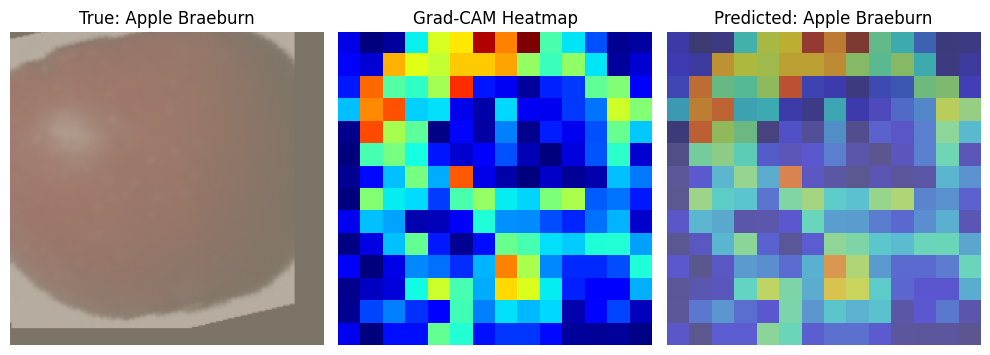

In [32]:
# Iterate over the test set
for i, (inputs, labels) in enumerate(test_loader):
    # Move the inputs and labels to the same device as the model
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass (do not use torch.no_grad() here, since Grad-CAM needs gradients)
    outputs = best_model(inputs)

    # Get the predicted class (index [0] extracts the value from the tensor)
    predicted = outputs.argmax(dim=1)[0].item()

    # Extract the CAM for the predicted class
    activation_map = cam_extractor(predicted, outputs)

    # Average the activation map across the channel dimension to get a 2D heatmap
    heatmap = activation_map[0].mean(dim=0).cpu().numpy()

    # Plotting
    plt.figure(figsize=(10, 5))

    # Original image
    ax1 = plt.subplot(1, 3, 1)
    img = denormalize(inputs[0], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img = img.permute(1, 2, 0).cpu().numpy()  # Move the tensor back to CPU for plotting
    ax1.imshow(img)
    ax1.set_title(f'True: {test_dataset.classes[labels[0].item()]}')  # Extract the scalar value from labels
    ax1.axis('off')

    # Heatmap
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(heatmap, cmap='jet')  # Display the 2D heatmap
    ax2.set_title('Grad-CAM Heatmap')
    ax2.axis('off')

    # Overlay the heatmap on the image
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(img)
    ax3.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay with transparency
    ax3.set_title(f'Predicted: {test_dataset.classes[predicted]}')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

    # Stop after the first example for demonstration; remove this line to iterate over all
    if i == 0:
        break

In [33]:
cam_extractor = GradCAM(model, target_layer='features.14')  # Try layer 14


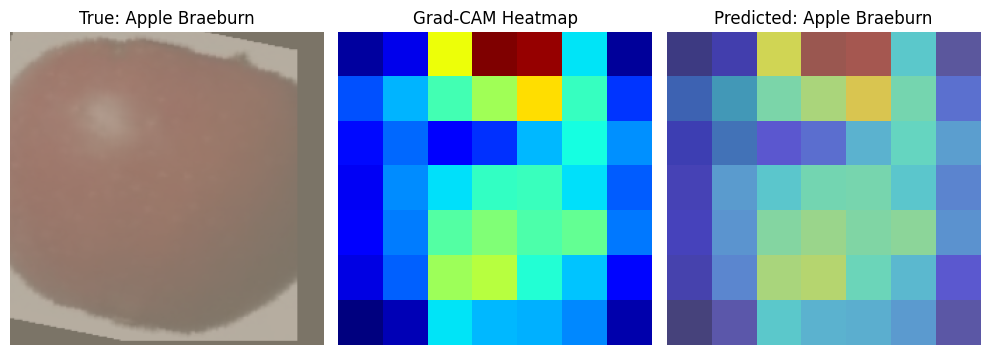

In [34]:
# Iterate over the test set
for i, (inputs, labels) in enumerate(test_loader):
    # Move the inputs and labels to the same device as the model
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass (do not use torch.no_grad() here, since Grad-CAM needs gradients)
    outputs = best_model(inputs)

    # Get the predicted class (index [0] extracts the value from the tensor)
    predicted = outputs.argmax(dim=1)[0].item()

    # Extract the CAM for the predicted class
    activation_map = cam_extractor(predicted, outputs)

    # Average the activation map across the channel dimension to get a 2D heatmap
    heatmap = activation_map[0].mean(dim=0).cpu().numpy()

    # Plotting
    plt.figure(figsize=(10, 5))

    # Original image
    ax1 = plt.subplot(1, 3, 1)
    img = denormalize(inputs[0], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img = img.permute(1, 2, 0).cpu().numpy()  # Move the tensor back to CPU for plotting
    ax1.imshow(img)
    ax1.set_title(f'True: {test_dataset.classes[labels[0].item()]}')  # Extract the scalar value from labels
    ax1.axis('off')

    # Heatmap
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(heatmap, cmap='jet')  # Display the 2D heatmap
    ax2.set_title('Grad-CAM Heatmap')
    ax2.axis('off')

    # Overlay the heatmap on the image
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(img)
    ax3.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay with transparency
    ax3.set_title(f'Predicted: {test_dataset.classes[predicted]}')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

    # Stop after the first example for demonstration; remove this line to iterate over all
    if i == 0:
        break

In [35]:
cam_extractor = GradCAM(model, target_layer='features.16')  # Try layer 16


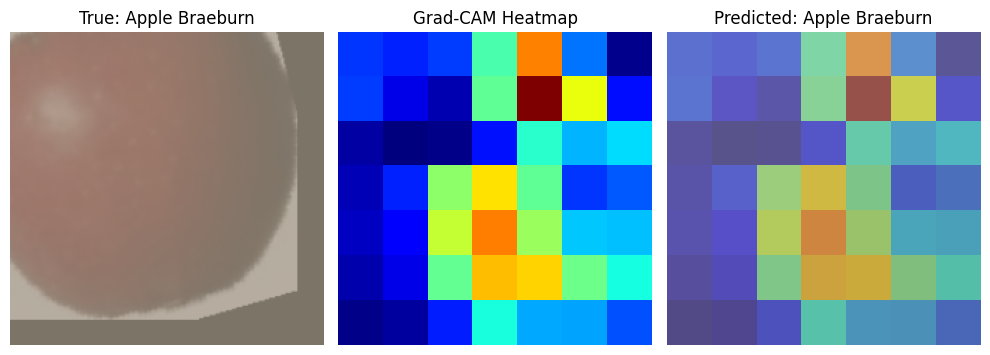

In [36]:
# Iterate over the test set
for i, (inputs, labels) in enumerate(test_loader):
    # Move the inputs and labels to the same device as the model
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass (do not use torch.no_grad() here, since Grad-CAM needs gradients)
    outputs = best_model(inputs)

    # Get the predicted class (index [0] extracts the value from the tensor)
    predicted = outputs.argmax(dim=1)[0].item()

    # Extract the CAM for the predicted class
    activation_map = cam_extractor(predicted, outputs)

    # Average the activation map across the channel dimension to get a 2D heatmap
    heatmap = activation_map[0].mean(dim=0).cpu().numpy()

    # Plotting
    plt.figure(figsize=(10, 5))

    # Original image
    ax1 = plt.subplot(1, 3, 1)
    img = denormalize(inputs[0], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img = img.permute(1, 2, 0).cpu().numpy()  # Move the tensor back to CPU for plotting
    ax1.imshow(img)
    ax1.set_title(f'True: {test_dataset.classes[labels[0].item()]}')  # Extract the scalar value from labels
    ax1.axis('off')

    # Heatmap
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(heatmap, cmap='jet')  # Display the 2D heatmap
    ax2.set_title('Grad-CAM Heatmap')
    ax2.axis('off')

    # Overlay the heatmap on the image
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(img)
    ax3.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay with transparency
    ax3.set_title(f'Predicted: {test_dataset.classes[predicted]}')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

    # Stop after the first example for demonstration; remove this line to iterate over all
    if i == 0:
        break